## From Landmarks to Animations

Víctor Ubieto | 2022

victoremilio.ubieto@upf.edu // victor.ubieto@e-campus.uab.cat

In [13]:
import os
import json
import math
import graphviz
import tensorflowjs as tfjs
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.models import load_model
from sklearn.model_selection import train_test_split

Let us first read the train and test files

In [2]:
train_data_dir = "E:\Documents\Projects\PycharmCurrent\Dataset"
train_data_dir_gt = "E:\Documents\Projects\PycharmCurrent\Dataset\gt"
data = []
gt_data = []

os.chdir(train_data_dir)
for file in os.listdir():
    if file.endswith(".json"):
        with open(file, 'r') as f:
            d = json.load(f)  # returns JSON object as a dictionary
            data = data + d

os.chdir(train_data_dir_gt)
for file in os.listdir():
    with open(file, 'r') as f:
        d = json.load(f)
        gt_data = gt_data + d

print(len(data)) # check data is something
print(len(gt_data)) # check data is something

2051
2051


Hyperparameters definition

In [3]:
n_epochs = 50
batch_size = 40
init_lr = 0.01
decay_stp = 10000
decay_rt = 0.9

#def step_decay(epoch):
#   initial_lrate = 0.001
#   drop = 0.5
#   epochs_drop = 50.0
#   lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#   return lrate
#lr_scheduler = LearningRateScheduler(step_decay)

lr_rate = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=decay_stp,
    decay_rate=decay_rt)

#optimizer = optimizers.Adam(learning_rate=0.0001)
optimizer = optimizers.Adamax(learning_rate=lr_rate)

#callbacks_list = [lr_scheduler]

Data preparation + data preprocessing, normalization?

Divide data in train-val-test

In [4]:
X_train, x_test, Y_train, y_test = train_test_split(data, gt_data, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25)  # 0.25 x 0.8 = 0.2
x_length = len(x_train[0])
y_length = len(y_train[0])

Model creation (https://www.tensorflow.org/tutorials/keras/regression)

In [5]:
model = Sequential()
model.add(layers.LayerNormalization(input_dim=x_length))
model.add(layers.Dense(256, activation="relu", name="layer1"))
model.add(layers.Dense(512, activation='relu', name="layer2"))
model.add(layers.Dense(1024, activation='relu', name="layer3"))
model.add(layers.Dense(512, activation='relu', name="layer4"))
model.add(layers.Dense(y_length, activation='linear', name="layer_out"))

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
model.summary()
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization (LayerN  (None, 225)              450       
 ormalization)                                                   
                                                                 
 layer1 (Dense)              (None, 256)               57856     
                                                                 
 layer2 (Dense)              (None, 512)               131584    
                                                                 
 layer3 (Dense)              (None, 1024)              525312    
                                                                 
 layer4 (Dense)              (None, 512)               524800    
                                                                 
 layer_out (Dense)           (None, 208)               106704    
                                                        

Training step

In [6]:
history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=n_epochs,
                validation_data=(x_val, y_val),
                #callbacks=callbacks_list
                )

Epoch 1/50
31/31 [==============================] - 2s 28ms/step - loss: 12.6372 - accuracy: 0.0211 - val_loss: 0.0121 - val_accuracy: 0.0000e+00
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0108 - accuracy: 0.0146 - val_loss: 0.0108 - val_accuracy: 0.1293
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0102 - accuracy: 0.1154 - val_loss: 0.0103 - val_accuracy: 0.0585
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0094 - accuracy: 0.1358 - val_loss: 0.0094 - val_accuracy: 0.2000
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0088 - accuracy: 0.1504 - val_loss: 0.0089 - val_accuracy: 0.1561
Epoch 6/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0084 - accuracy: 0.1821 - val_loss: 0.0085 - val_accuracy: 0.1439
Epoch 7/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0081 - accuracy: 0.1537 - val_loss: 0.0084 - val_accuracy: 0.0732
Epoch 8/50
31/

Evaluation

(Refination, hyperparameter tuning)?

#Train Data#     Loss: 0.00211    Accuracy: 8.13
#Test  Data#     Loss: 0.00219    Accuracy: 6.33


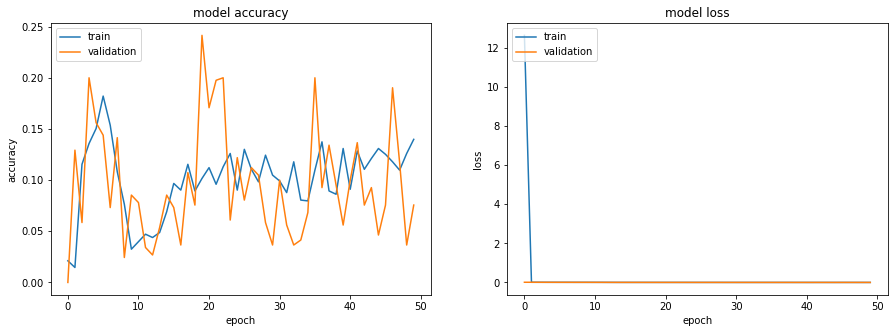

Epochs: 50    Batch Size: 40    Optimitzer: Adamax    Init LR: 0.01    Decay Step: 10000    Decay Rate: 0.9


In [7]:
train_mse = model.evaluate(x_train, y_train, verbose=0)
test_mse = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
print('#Train Data#     Loss: %.5f' % train_mse[0] + '    Accuracy: %.2f' % (train_mse[1]*100))
print('#Test  Data#     Loss: %.5f' % test_mse[0]  + '    Accuracy: %.2f' % (test_mse[1]*100))

# Plots
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Summarize history for accuracy
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.title.set_text('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')

# Summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.title.set_text('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()
plt.savefig('accuracy.jpg')
plt.close()

print('Epochs: ' + str(n_epochs) + '    Batch Size: ' + str(batch_size) + '    Optimitzer: ' + str(optimizer._name)
      + '    Init LR: ' + str(init_lr) + '    Decay Step: ' + str(decay_stp) + '    Decay Rate: ' + str(decay_rt))

Store the Model

In [14]:
# Serialize model to JSON
model_json = model.to_json()
with open("E:\Documents\Projects\PycharmCurrent\MLmodel.json", "w") as json_file:
    json_file.write(model_json)
tfjs.converters.save_keras_model(model, "E:\Documents\Projects\PycharmCurrent\MLstuff")

FUTURE TASKS CODE

In [ ]:
# Compute and store the result
# TODO Use the data from the webcam
result = model.predict(x_test, batch_size=batch_size)

with open("results.json", 'w') as file:
    json.dump(result.tolist(), file, indent=4)

# Save the model
filepath = 'saved_model'
model.save(filepath)

# Load the model
model = load_model(filepath, compile = True)